In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

In [2]:
try:
    from numba import jit,vectorize,float64,float32,int64,int32,boolean,guvectorize
    print("Imported Numba")
except ImportError:
    print("Error")
pass

Imported Numba


In [3]:
#Esercizio 1
@jit(nopython=True,nogil=True)
def sampleDecay(tau, maxSteps, th0):
    thCount = np.zeros(maxSteps)
    thCount[0] = th0
    stopTime = maxSteps
    p_decay = 1 - 2**(-1/tau) 
    for i in range(1,maxSteps):
        if thCount[i-1] == 0:
            stopTime = i-1
            break
        mask = np.random.rand(int(thCount[i-1])) <= p_decay
        thCount[i]=thCount[i-1]-len(mask[mask])
    return thCount[0:stopTime]

@jit(nopython=True,nogil=True)
def gillespieDecay(tau, steps, th0):
    wTimes = np.sort((-tau/np.log(2))*np.log(np.random.rand(steps)))
    return np.vstack((wTimes, np.arange(th0,th0-steps,-1)))

In [4]:
tau = 3.052*60
steps = 1000
th0=1000

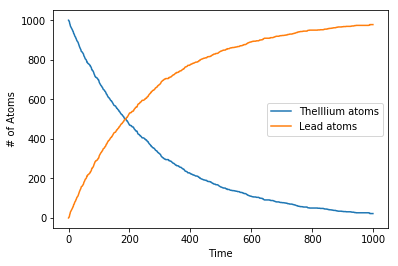

In [5]:
#first way
thCount = sampleDecay(tau, steps, th0)
plt.plot(thCount,label='Thelllium atoms')
plt.plot(th0-thCount,label='Lead atoms')
plt.xlabel("Time")
plt.ylabel("# of Atoms")
plt.legend()
plt.show()

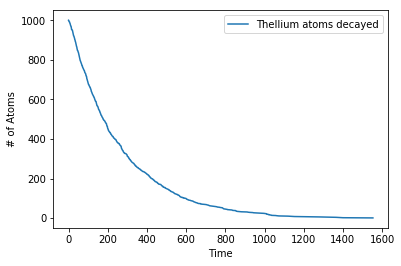

In [6]:
thDecay = gillespieDecay(tau, steps, th0)
plt.plot(thDecay[0,:],thDecay[1,:], label="Thellium atoms decayed")
plt.xlabel("Time")
plt.ylabel("# of Atoms")
plt.legend()
plt.show()

In [7]:
#Esercizio 2

In [8]:
Z=79
q_e = 1.60218E-19 #Coulombs
e0 = 8.854187817E-12
E = 7.7*(q_e*1E6)
a0 = 0.5292E-10
sigma = a0/100
beam = np.random.randn(2,1000000)*sigma
factor = (Z*q_e*q_e)/(2*np.pi*e0*E)
b = np.sqrt(beam[0,:]**2+beam[1,:]**2) #fix this one
angles = 2*np.arctan(factor/b)
mask = angles > np.pi/2

In [9]:
#Esercizio 3
@jit
def hitMissIntegration(f, a, b, nSamples):
    x = np.random.rand(nSamples)*(b-a)+a
    f_x = f(x)
    min_f = np.min(f_x)
    max_f = np.max(f_x)
    y = np.random.rand(nSamples)*(max_f-min_f)+min_f
    hits = f_x[y < f_x]
    return 2*len(hits)/nSamples
@jit
def meanValIntegration(f, a, b, nSamples, estimateError=False):
    x = np.random.rand(nSamples)*(b-a)+a
    f_x  =  f(x)
    intVal = 2*np.sum(f_x)/nSamples
    if estimateError:
        return intVal, (b-a)*np.std(f_x)/np.sqrt(nSamples)
    else:
        return intVal

In [10]:
f = lambda x:  (np.sin(1/(x*(2-x))))**2

In [11]:
import scipy.integrate as integrate
a = 0
b = 2
trueVal,_ = integrate.quad(f,a,b)
hmInt = hitMissIntegration(f,a,b,1000000)
print("Hit/Miss Integration:",hmInt , "with error", np.abs(trueVal-hmInt))
mvInt,_ = meanValIntegration(f,a,b,1000000,True)
print("Mean Value Integration:", mvInt, "with error", np.abs(trueVal-mvInt))

/opt/ubuntu-16.04/conda/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Hit/Miss Integration: 1.451616 with error 7.175098106837474e-05
Mean Value Integration: 1.4507206811098932 with error 0.0009670698711752301


In [12]:
#Esercizio 4

In [13]:
@jit
def insideSphere(x):
    return np.linalg.norm(x,axis=0) <= 1

In [14]:
d=9
nSamples = 10000000

pts = np.random.rand(d,nSamples)
hit = len(pts[0,:][insideSphere(pts)])
print(hit*2**d/nSamples)

3.3048576


In [15]:
#Esercizio 5
@jit(nopython=True,nogil=True)
def sampleSqrtLaw(nSamples):
    return np.random.rand(nSamples)**2

In [16]:
fIntg = lambda x: np.sqrt(1/x)/(np.exp(x)+1)

In [17]:
#this employs inverse transform + importance sampling
nSamples = 10000000
samples = sampleSqrtLaw(nSamples)
print(np.sum(2*np.sqrt(samples)*fIntg(samples))/nSamples)

0.839005344920137
